In [ ]:
!pip uninstall byol-pytorch

In [ ]:
!pip install torchlars

  Created wheel for torchlars: filename=torchlars-0.1.2-cp37-cp37m-linux_x86_64.whl size=2198275 sha256=26311de5923de8b444165fb12e086414d3714f57408513fd607e3d558f968b20
  Stored in directory: /root/.cache/pip/wheels/ae/a9/96/62995a5abfd27e2f46671e17b99a52b6dccf46391d2b0e1c17
Successfully built torchlars


In [ ]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 256

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


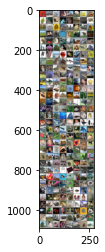

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [ ]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

In [ ]:
images.shape

torch.Size([256, 3, 32, 32])

In [ ]:
for i,(images,labels) in enumerate(trainloader):
  print(images.shape)
  break

torch.Size([256, 3, 32, 32])


In [ ]:
import copy
import random
from functools import wraps

import torch
from torch import nn
import torch.nn.functional as F

from torchvision import transforms as T

# helper functions

def default(val, def_val):
    return def_val if val is None else val

def flatten(t):
    return t.reshape(t.shape[0], -1)

def singleton(cache_key):
    def inner_fn(fn):
        @wraps(fn)
        def wrapper(self, *args, **kwargs):
            instance = getattr(self, cache_key)
            if instance is not None:
                return instance

            instance = fn(self, *args, **kwargs)
            setattr(self, cache_key, instance)
            return instance
        return wrapper
    return inner_fn

def get_module_device(module):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if device == torch.device('cuda'): print("Running on GPU",torch.cuda.get_device_name(0))
    else: print("Running on CPU")
    return device
    # return next(module.parameters()).device

def set_requires_grad(model, val):
    for p in model.parameters():
        p.requires_grad = val

# loss fn

def loss_fn(x, y):
    x = F.normalize(x, dim=-1, p=2)
    y = F.normalize(y, dim=-1, p=2)
    return 2 - 2 * (x * y).sum(dim=-1)

# augmentation utils

class RandomApply(nn.Module):
    def __init__(self, fn, p):
        super().__init__()
        self.fn = fn
        self.p = p
    def forward(self, x):
        if random.random() > self.p:
            return x
        return self.fn(x)

# exponential moving average

class EMA():
    def __init__(self, beta):
        super().__init__()
        self.beta = beta

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

def update_moving_average(ema_updater, ma_model, current_model):
    for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
        old_weight, up_weight = ma_params.data, current_params.data
        ma_params.data = ema_updater.update_average(old_weight, up_weight)

# MLP class for projector and predictor

def MLP(dim, projection_size, hidden_size=4096):
    return nn.Sequential(
        nn.Linear(dim, hidden_size),
        nn.BatchNorm1d(hidden_size),
        nn.ReLU(inplace=True),
        nn.Linear(hidden_size, projection_size)
    )

def SimSiamMLP(dim, projection_size, hidden_size=4096):
    return nn.Sequential(
        nn.Linear(dim, hidden_size, bias=False),
        nn.BatchNorm1d(hidden_size),
        nn.ReLU(inplace=True),
        nn.Linear(hidden_size, hidden_size, bias=False),
        nn.BatchNorm1d(hidden_size),
        nn.ReLU(inplace=True),
        nn.Linear(hidden_size, projection_size, bias=False),
        nn.BatchNorm1d(projection_size, affine=False)
    )

# a wrapper class for the base neural network
# will manage the interception of the hidden layer output
# and pipe it into the projecter and predictor nets

class NetWrapper(nn.Module):
    def __init__(self, net, projection_size, projection_hidden_size, layer = -2, use_simsiam_mlp = False):
        super().__init__()
        self.net = net
        self.layer = layer

        self.projector = None
        self.projection_size = projection_size
        self.projection_hidden_size = projection_hidden_size

        self.use_simsiam_mlp = use_simsiam_mlp

        self.hidden = {}
        self.hook_registered = False

    def _find_layer(self):
        if type(self.layer) == str:
            modules = dict([*self.net.named_modules()])
            return modules.get(self.layer, None)
        elif type(self.layer) == int:
            children = [*self.net.children()]
            return children[self.layer]
        return None

    def _hook(self, _, input, output):
        device = input[0].device
        self.hidden[device] = flatten(output)

    def _register_hook(self):
        layer = self._find_layer()
        assert layer is not None, f'hidden layer ({self.layer}) not found'
        handle = layer.register_forward_hook(self._hook)
        self.hook_registered = True

    @singleton('projector')
    def _get_projector(self, hidden):
        _, dim = hidden.shape
        create_mlp_fn = MLP if not self.use_simsiam_mlp else SimSiamMLP
        projector = create_mlp_fn(dim, self.projection_size, self.projection_hidden_size)
        return projector.to(hidden)

    def get_representation(self, x):
        if self.layer == -1:
            return self.net(x)

        if not self.hook_registered:
            self._register_hook()

        self.hidden.clear()
        _ = self.net(x)
        hidden = self.hidden[x.device]
        self.hidden.clear()

        assert hidden is not None, f'hidden layer {self.layer} never emitted an output'
        return hidden

    def forward(self, x, return_projection = True):
        representation = self.get_representation(x)

        if not return_projection:
            return representation

        projector = self._get_projector(representation)
        projection = projector(representation)
        return projection, representation

# main class

class BYOL(nn.Module):
    def __init__(
        self,
        net,
        image_size,
        hidden_layer = -2,
        projection_size = 256,
        projection_hidden_size = 4096,
        augment_fn = None,
        augment_fn2 = None,
        moving_average_decay = 0.99,
        use_momentum = True
    ):
        super().__init__()
        self.net = net

        # default SimCLR augmentation

        DEFAULT_AUG = torch.nn.Sequential(
            RandomApply(
                T.ColorJitter(0.8, 0.8, 0.8, 0.2),
                p = 0.3
            ),
            T.RandomGrayscale(p=0.2),
            T.RandomHorizontalFlip(),
            RandomApply(
                T.GaussianBlur((3, 3), (1.0, 2.0)),
                p = 0.2
            ),
            T.RandomResizedCrop((image_size, image_size)),
            T.Normalize(
                mean=torch.tensor([0.485, 0.456, 0.406]),
                std=torch.tensor([0.229, 0.224, 0.225])),
        )

        self.augment1 = default(augment_fn, DEFAULT_AUG)
        self.augment2 = default(augment_fn2, self.augment1)

        self.online_encoder = NetWrapper(net, projection_size, projection_hidden_size, layer=hidden_layer, use_simsiam_mlp=not use_momentum)

        self.use_momentum = use_momentum
        self.target_encoder = None
        self.target_ema_updater = EMA(moving_average_decay)

        self.online_predictor = MLP(projection_size, projection_size, projection_hidden_size)

        # get device of network and make wrapper same device
        device = get_module_device(net)
        self.to(device)

        # send a mock image tensor to instantiate singleton parameters
        self.forward(torch.randn(2, 3, image_size, image_size, device=device))

    @singleton('target_encoder')
    def _get_target_encoder(self):
        target_encoder = copy.deepcopy(self.online_encoder)
        set_requires_grad(target_encoder, False)
        return target_encoder

    def reset_moving_average(self):
        del self.target_encoder
        self.target_encoder = None

    def update_moving_average(self):
        assert self.use_momentum, 'you do not need to update the moving average, since you have turned off momentum for the target encoder'
        assert self.target_encoder is not None, 'target encoder has not been created yet'
        update_moving_average(self.target_ema_updater, self.target_encoder, self.online_encoder)

    def forward(
        self,
        x,
        return_embedding = False,
        return_projection = True
    ):
        assert not (self.training and x.shape[0] == 1), 'you must have greater than 1 sample when training, due to the batchnorm in the projection layer'

        if return_embedding:
            return self.online_encoder(x, return_projection = return_projection)

        image_one, image_two = self.augment1(x), self.augment2(x)

        online_proj_one, _ = self.online_encoder(image_one)
        online_proj_two, _ = self.online_encoder(image_two)

        online_pred_one = self.online_predictor(online_proj_one)
        online_pred_two = self.online_predictor(online_proj_two)

        with torch.no_grad():
            target_encoder = self._get_target_encoder() if self.use_momentum else self.online_encoder
            target_proj_one, _ = target_encoder(image_one)
            target_proj_two, _ = target_encoder(image_two)
            target_proj_one.detach_()
            target_proj_two.detach_()

        loss_one = loss_fn(online_pred_one, target_proj_two.detach())
        loss_two = loss_fn(online_pred_two, target_proj_one.detach())

        loss = loss_one + loss_two
        return loss.mean()

In [ ]:
import torch
# from byol_pytorch import BYOL
from torchvision import models
import time
import torchvision
import torchvision.transforms as transforms
from torchlars import LARS
from tqdm import tqdm

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 4096

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

resnet = models.resnet18()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device == torch.device('cuda'): print("Running on GPU",torch.cuda.get_device_name(0))
else: print("Running on CPU")

learner = BYOL(
    resnet,
    image_size = 32,
    hidden_layer = 'avgpool'
)

# opt = torch.optim.Adam(learner.parameters(), lr=3e-4)
base_optimizer = torch.optim.SGD(resnet.parameters(), lr=0.1)
opt = LARS(optimizer=base_optimizer, eps=1e-8, trust_coef=0.001)


# def sample_unlabelled_images():
#     return torch.randn(20, 3, 256, 256)

resnet = resnet.to(device)
for epoch in range(100):
    for (images,_) in tqdm(trainloader): # _ = labels
      start = time.time()
      # images = sample_unlabelled_images()
      loss = learner(images.to(device))
      opt.zero_grad()
      loss.backward()
      opt.step()
      learner.update_moving_average() # update moving average of target encoder
    print(f"Epoch {epoch} loss {loss} took {time.time()-start}")

    # save your improved network
    path = "/content/drive/MyDrive/simsiam"
    torch.save(resnet.state_dict(), f'{path}/improved-net-epoch-{epoch}.pt')

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
Running on GPU Tesla K80
Running on GPU Tesla K80


  0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torchlars/lars.py:140: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1050.)
  p.grad.add_(weight_decay, p.data)
100%|██████████| 13/13 [01:43<00:00,  7.96s/it]


Epoch 0 loss 3.8869969844818115 took 2.7597849369049072


100%|██████████| 13/13 [01:44<00:00,  8.02s/it]


Epoch 1 loss 3.8477320671081543 took 2.781032085418701


100%|██████████| 13/13 [01:26<00:00,  6.63s/it]


Epoch 2 loss 3.815053701400757 took 2.7545487880706787


100%|██████████| 13/13 [01:38<00:00,  7.57s/it]


Epoch 3 loss 3.809530735015869 took 3.9256529808044434


100%|██████████| 13/13 [01:20<00:00,  6.21s/it]


Epoch 4 loss 3.8428938388824463 took 3.9156506061553955


100%|██████████| 13/13 [01:39<00:00,  7.63s/it]


Epoch 5 loss 3.7394473552703857 took 4.246051549911499


100%|██████████| 13/13 [01:33<00:00,  7.16s/it]


Epoch 6 loss 3.728030204772949 took 3.82334041595459


100%|██████████| 13/13 [01:49<00:00,  8.43s/it]


Epoch 7 loss 3.5958430767059326 took 2.7757058143615723


100%|██████████| 13/13 [01:32<00:00,  7.11s/it]


Epoch 8 loss 3.5829784870147705 took 2.796215057373047


100%|██████████| 13/13 [01:21<00:00,  6.27s/it]


Epoch 9 loss 3.4982213973999023 took 3.917039155960083


100%|██████████| 13/13 [01:37<00:00,  7.54s/it]


Epoch 10 loss 3.411498546600342 took 2.7567996978759766


100%|██████████| 13/13 [01:26<00:00,  6.67s/it]


Epoch 11 loss 3.421762704849243 took 2.8331875801086426


100%|██████████| 13/13 [01:27<00:00,  6.74s/it]


Epoch 12 loss 3.4536075592041016 took 3.860532522201538


100%|██████████| 13/13 [01:27<00:00,  6.73s/it]


Epoch 13 loss 3.2016069889068604 took 3.2072412967681885


100%|██████████| 13/13 [01:26<00:00,  6.66s/it]


Epoch 14 loss 3.3088529109954834 took 3.8757221698760986


100%|██████████| 13/13 [01:49<00:00,  8.43s/it]


Epoch 15 loss 3.1142642498016357 took 2.7776939868927


100%|██████████| 13/13 [01:49<00:00,  8.45s/it]


Epoch 16 loss 3.2517948150634766 took 3.876756191253662


100%|██████████| 13/13 [01:37<00:00,  7.49s/it]


Epoch 17 loss 2.976464033126831 took 3.236629009246826


100%|██████████| 13/13 [01:43<00:00,  7.97s/it]


Epoch 18 loss 2.67582631111145 took 7.082330942153931


100%|██████████| 13/13 [01:20<00:00,  6.20s/it]


Epoch 19 loss 2.6161580085754395 took 2.7759950160980225


100%|██████████| 13/13 [01:49<00:00,  8.43s/it]


Epoch 20 loss 2.6353063583374023 took 2.7971787452697754


100%|██████████| 13/13 [02:02<00:00,  9.39s/it]


Epoch 21 loss 2.6325833797454834 took 8.093005180358887


100%|██████████| 13/13 [01:38<00:00,  7.56s/it]


Epoch 22 loss 2.5786197185516357 took 3.826885223388672


100%|██████████| 13/13 [01:14<00:00,  5.77s/it]


Epoch 23 loss 2.3136985301971436 took 2.8013057708740234


100%|██████████| 13/13 [01:20<00:00,  6.19s/it]


Epoch 24 loss 2.098641872406006 took 2.7655277252197266


100%|██████████| 13/13 [01:39<00:00,  7.65s/it]


Epoch 25 loss 2.3187851905822754 took 3.7970504760742188


100%|██████████| 13/13 [01:43<00:00,  7.96s/it]


Epoch 26 loss 1.9484554529190063 took 2.7634317874908447


100%|██████████| 13/13 [01:32<00:00,  7.08s/it]


Epoch 27 loss 1.8226640224456787 took 2.7611424922943115


100%|██████████| 13/13 [01:44<00:00,  8.01s/it]


Epoch 28 loss 2.1734485626220703 took 3.9327609539031982


100%|██████████| 13/13 [01:32<00:00,  7.09s/it]


Epoch 29 loss 1.9889085292816162 took 2.7881362438201904


100%|██████████| 13/13 [01:32<00:00,  7.13s/it]


Epoch 30 loss 1.9466979503631592 took 3.9290621280670166


100%|██████████| 13/13 [01:21<00:00,  6.26s/it]


Epoch 31 loss 1.9119137525558472 took 2.786527156829834


100%|██████████| 13/13 [01:38<00:00,  7.56s/it]


Epoch 32 loss 2.1720104217529297 took 7.087858200073242


100%|██████████| 13/13 [01:27<00:00,  6.69s/it]


Epoch 33 loss 1.6401790380477905 took 3.8311619758605957


100%|██████████| 13/13 [01:38<00:00,  7.56s/it]


Epoch 34 loss 1.7365097999572754 took 7.665803909301758


100%|██████████| 13/13 [01:14<00:00,  5.76s/it]


Epoch 35 loss 1.4290480613708496 took 2.7698919773101807


100%|██████████| 13/13 [01:38<00:00,  7.56s/it]


Epoch 36 loss 1.3740848302841187 took 2.7564797401428223


100%|██████████| 13/13 [01:44<00:00,  8.03s/it]


Epoch 37 loss 1.6897330284118652 took 3.812774181365967


100%|██████████| 13/13 [01:32<00:00,  7.14s/it]


Epoch 38 loss 1.515105128288269 took 3.229015350341797


100%|██████████| 13/13 [01:14<00:00,  5.75s/it]


Epoch 39 loss 1.5510616302490234 took 3.8761281967163086


100%|██████████| 13/13 [01:32<00:00,  7.09s/it]


Epoch 40 loss 1.4140619039535522 took 3.2287824153900146


100%|██████████| 13/13 [01:33<00:00,  7.17s/it]


Epoch 41 loss 1.346457600593567 took 3.8412461280822754


100%|██████████| 13/13 [01:32<00:00,  7.10s/it]


Epoch 42 loss 1.2882909774780273 took 2.766111135482788


100%|██████████| 13/13 [01:32<00:00,  7.12s/it]


Epoch 43 loss 1.2524757385253906 took 2.752950429916382


100%|██████████| 13/13 [01:26<00:00,  6.62s/it]


Epoch 44 loss 1.2263388633728027 took 2.747525930404663


100%|██████████| 13/13 [01:32<00:00,  7.11s/it]


Epoch 45 loss 1.3541797399520874 took 3.8681299686431885


100%|██████████| 13/13 [01:49<00:00,  8.42s/it]


Epoch 46 loss 1.2950439453125 took 7.057995796203613


100%|██████████| 13/13 [01:33<00:00,  7.22s/it]


Epoch 47 loss 1.3531023263931274 took 4.874835252761841


100%|██████████| 13/13 [01:49<00:00,  8.42s/it]


Epoch 48 loss 1.3311632871627808 took 7.101595401763916


100%|██████████| 13/13 [01:55<00:00,  8.92s/it]


Epoch 49 loss 1.2602752447128296 took 2.7606968879699707


100%|██████████| 13/13 [01:26<00:00,  6.64s/it]


Epoch 50 loss 1.1172927618026733 took 2.7713563442230225


100%|██████████| 13/13 [01:32<00:00,  7.12s/it]


Epoch 51 loss 1.2570412158966064 took 2.800614356994629


100%|██████████| 13/13 [01:43<00:00,  7.95s/it]


Epoch 52 loss 1.1547125577926636 took 7.594263792037964


100%|██████████| 13/13 [01:43<00:00,  7.98s/it]


Epoch 53 loss 1.0863385200500488 took 2.753312349319458


100%|██████████| 13/13 [01:37<00:00,  7.52s/it]


Epoch 54 loss 1.1157276630401611 took 7.0947020053863525


100%|██████████| 13/13 [01:26<00:00,  6.63s/it]


Epoch 55 loss 1.1709799766540527 took 2.789276599884033


100%|██████████| 13/13 [01:32<00:00,  7.10s/it]


Epoch 56 loss 1.1009050607681274 took 2.808081865310669


100%|██████████| 13/13 [01:32<00:00,  7.15s/it]


Epoch 57 loss 1.1431968212127686 took 3.7902047634124756


100%|██████████| 13/13 [01:43<00:00,  7.98s/it]


Epoch 58 loss 0.9556474089622498 took 2.755382537841797


100%|██████████| 13/13 [01:38<00:00,  7.56s/it]


Epoch 59 loss 1.0330535173416138 took 2.7914795875549316


100%|██████████| 13/13 [01:44<00:00,  8.01s/it]


Epoch 60 loss 1.073561429977417 took 3.8716118335723877


100%|██████████| 13/13 [01:20<00:00,  6.22s/it]


Epoch 61 loss 1.3627923727035522 took 3.8574514389038086


100%|██████████| 13/13 [01:43<00:00,  7.98s/it]


Epoch 62 loss 1.0284196138381958 took 2.776184558868408


100%|██████████| 13/13 [01:14<00:00,  5.75s/it]


Epoch 63 loss 0.9743063449859619 took 2.77410888671875


100%|██████████| 13/13 [01:26<00:00,  6.67s/it]


Epoch 64 loss 0.7901211380958557 took 2.7645671367645264


100%|██████████| 13/13 [01:31<00:00,  7.08s/it]


Epoch 65 loss 0.8285326361656189 took 2.7667300701141357


100%|██████████| 13/13 [01:20<00:00,  6.22s/it]


Epoch 66 loss 0.904052734375 took 3.164600133895874


100%|██████████| 13/13 [01:37<00:00,  7.52s/it]


Epoch 67 loss 1.0269957780838013 took 3.181727170944214


100%|██████████| 13/13 [01:15<00:00,  5.78s/it]


Epoch 68 loss 0.8519207239151001 took 3.9110305309295654


100%|██████████| 13/13 [01:31<00:00,  7.07s/it]


Epoch 69 loss 0.9774245023727417 took 7.1018147468566895


100%|██████████| 13/13 [01:26<00:00,  6.65s/it]


Epoch 70 loss 1.0115041732788086 took 2.7561120986938477


100%|██████████| 13/13 [01:49<00:00,  8.40s/it]


Epoch 71 loss 1.1417105197906494 took 2.7912375926971436


100%|██████████| 13/13 [01:43<00:00,  7.99s/it]


Epoch 72 loss 0.9025158286094666 took 2.7637996673583984


100%|██████████| 13/13 [01:43<00:00,  7.98s/it]


Epoch 73 loss 0.8416277170181274 took 3.2201876640319824


100%|██████████| 13/13 [01:55<00:00,  8.86s/it]


Epoch 74 loss 0.7589878439903259 took 3.8528850078582764


100%|██████████| 13/13 [01:45<00:00,  8.09s/it]


Epoch 75 loss 0.9226676225662231 took 3.8094873428344727


100%|██████████| 13/13 [01:26<00:00,  6.66s/it]


Epoch 76 loss 0.797680675983429 took 2.7651679515838623


100%|██████████| 13/13 [01:50<00:00,  8.48s/it]


Epoch 77 loss 0.8812906742095947 took 3.837599039077759


100%|██████████| 13/13 [01:37<00:00,  7.51s/it]


Epoch 78 loss 0.90949946641922 took 7.044251441955566


100%|██████████| 13/13 [01:37<00:00,  7.52s/it]


Epoch 79 loss 1.1396807432174683 took 3.867189884185791


100%|██████████| 13/13 [01:26<00:00,  6.66s/it]


Epoch 80 loss 0.9177427887916565 took 8.212174654006958


100%|██████████| 13/13 [01:44<00:00,  8.00s/it]


Epoch 81 loss 0.7950001955032349 took 3.866413116455078


100%|██████████| 13/13 [01:43<00:00,  8.00s/it]


Epoch 82 loss 0.8618013858795166 took 4.2958362102508545


100%|██████████| 13/13 [01:31<00:00,  7.08s/it]


Epoch 83 loss 0.8155848979949951 took 2.735994577407837


100%|██████████| 13/13 [01:49<00:00,  8.44s/it]


Epoch 84 loss 0.7919928431510925 took 2.751661777496338


100%|██████████| 13/13 [01:37<00:00,  7.53s/it]


Epoch 85 loss 0.9324493408203125 took 2.81292724609375


100%|██████████| 13/13 [01:14<00:00,  5.73s/it]


Epoch 86 loss 1.0254007577896118 took 2.8053908348083496


100%|██████████| 13/13 [01:26<00:00,  6.66s/it]


Epoch 87 loss 0.7952294945716858 took 2.8021576404571533


100%|██████████| 13/13 [01:43<00:00,  7.97s/it]


Epoch 88 loss 0.7751660943031311 took 2.7358455657958984


100%|██████████| 13/13 [01:27<00:00,  6.76s/it]


Epoch 89 loss 1.0362001657485962 took 4.866618633270264


100%|██████████| 13/13 [01:27<00:00,  6.71s/it]


Epoch 90 loss 0.7343270182609558 took 3.84035587310791


100%|██████████| 13/13 [01:55<00:00,  8.88s/it]


Epoch 91 loss 0.8882573246955872 took 7.060574769973755


100%|██████████| 13/13 [02:12<00:00, 10.22s/it]


Epoch 92 loss 0.9311686158180237 took 7.102674961090088


100%|██████████| 13/13 [01:55<00:00,  8.91s/it]


Epoch 93 loss 0.6328930258750916 took 8.196528434753418


100%|██████████| 13/13 [01:32<00:00,  7.08s/it]


Epoch 94 loss 0.7999508380889893 took 2.749565601348877


100%|██████████| 13/13 [01:21<00:00,  6.27s/it]


Epoch 95 loss 0.8408711552619934 took 3.7968387603759766


100%|██████████| 13/13 [01:32<00:00,  7.10s/it]


Epoch 96 loss 0.7182257175445557 took 8.148650407791138


100%|██████████| 13/13 [01:26<00:00,  6.64s/it]


Epoch 97 loss 0.6631855368614197 took 2.7350821495056152


100%|██████████| 13/13 [01:38<00:00,  7.60s/it]


Epoch 98 loss 0.8454692363739014 took 3.79474139213562


100%|██████████| 13/13 [01:26<00:00,  6.64s/it]


Epoch 99 loss 0.6917436718940735 took 2.7435672283172607
